# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Load the classes
import csv
with open('signnames.csv') as f:
    sign_names = list(csv.reader(f))[1:]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(sign_names)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


---
### Sample Data Visualization & Enhancement

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

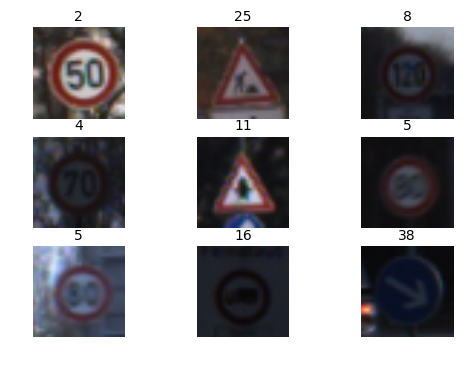

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline

# Visualize a traffic sign
img_list = []
for i in range(9):
    plt.subplot(3,3,i+1)
    num = randint(0,n_train)
    img_list.append(num)
    image = X_train[num]
    plt.imshow(image)
    plt.title(sign_names[y_train[num]][0],fontsize=10)
    #plt.title("#{} -".format(num) + sign_names[y_train[num]][1] + ' - Before Enhancement')
    plt.axis('off')
plt.show()

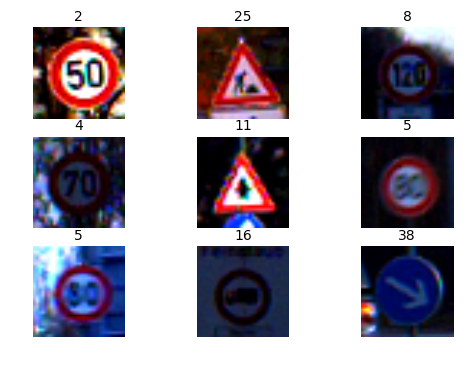

In [4]:
# After enhancement
from PIL import Image,ImageEnhance
def enhance(image):
    img = Image.fromarray(image)
    factor = 2.0
    color = ImageEnhance.Color(img)
    img = color.enhance(factor)
    sharpness = ImageEnhance.Sharpness(img)
    img = sharpness.enhance(factor)
    contrast = ImageEnhance.Contrast(img)
    img = contrast.enhance(factor)
    return img

for i in range(9):
    plt.subplot(3,3,i+1)
    num = img_list[i]
    image = X_train[num]
    plt.imshow(enhance(image))
    plt.title(sign_names[y_train[num]][0],fontsize=10)
    plt.axis('off')
plt.show()

# Enhance all images in training/test sets
import tqdm

ENHANCE = False
if ENHANCE:
    for i in tqdm.tqdm(range(n_train)):
        X_train[i] = enhance(X_train[i])
    
    for i in tqdm.tqdm(range(n_test)):
        X_test[i] = enhance(X_test[i])

    print("Training/Test images enhanced!")

## Histogram of training dataset
Here we check to see how many examples we have for each dataset

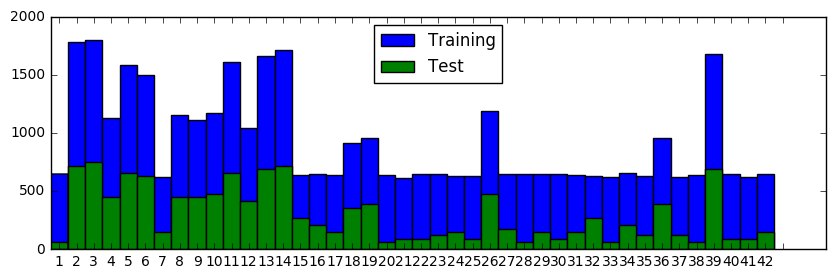

In [27]:
plt.figure(figsize=(10,3))
plt.hist(y_train,bins=range(n_classes),label='Training')
plt.hist(y_test,bins=range(n_classes),label='Test')
plt.legend(loc='best')
plt.xticks(np.arange(0.5,43.5,1.0),np.arange(1,43,1))
plt.show()

## Data Augmentation
In this section, we try to add more data examples where there are fewer than *THRESHOLD* data cases. 

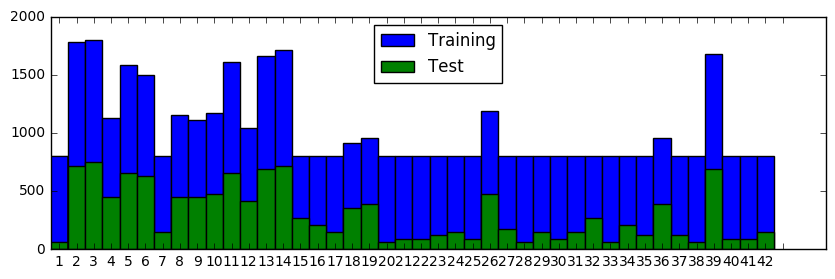

In [29]:
import numpy as np
from random import randint
THRESHOLD = 800
yhist,cases = np.histogram(y_train,bins=range(n_classes))

# Function to return a random image from training set that corresponds to provided case
A = np.array(range(len(y_train)))
def get_random_case(c,num=1):
    return np.random.choice(A[y_train==c],num)

def transform(img):
    return np.array([img])

X_train_augmented=[X_train]
y_train_augmented=[y_train]

for y,c in zip(yhist,cases):
    diff = THRESHOLD-y
    if diff>0:
        #print("Case {} has fewer than {}: {}.. Adding {}".format(c,THRESHOLD,y,diff))
        
        # Get random images for this case
        rand_imgs = get_random_case(c,diff)
        
        # Apply a small random transformation
        for i in tqdm.tqdm(range(diff)):
            imgi_mod = transform(X_train[rand_imgs[i]])
            
            # Store it in traning set
            X_train_augmented.append(imgi_mod)
            y_train_augmented.append([c])
            
X_train=np.concatenate(X_train_augmented,axis=0)
y_train=np.concatenate(y_train_augmented,axis=0)

# Plot new histogram
plt.figure(figsize=(10,3))
plt.hist(y_train,bins=range(n_classes),label='Training')
plt.hist(y_test,bins=range(n_classes),label='Test')
plt.legend(loc='best')
plt.xticks(np.arange(0.5,43.5,1.0),np.arange(1,43,1))
plt.show()


In [7]:
# After augmentation
print("Shape of training data set (X)= {}".format(X_train.shape))
print("Shape of training data set (y)= {}".format(y_train.shape))

Shape of training data set (X)= (48710, 32, 32, 3)
Shape of training data set (y)= (48710,)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
As you can see in the above sections, I have kept all three channels of the original image. The reason I chose not to convert to grayscale is that I wanted the deep-neural-net to use the colors within the feature-set in addition to the shapes (some have blue, others have red etc.). I modified the LeNet architecture to use three channels of input.

Many of the images (after being cropped and resampled) are not very clear in terms of contrast, brightness or sharpness. I attempted to use the OpenCV module function *ImageEnhance* to improve these aspects of the images, however I noticed that this decreased the resulting validation/testing accuracy in the end, so I have disabled image enhancement for now. In future, I will attempt to do a more surgical enhancement using my own normalization techniques and see if that helps

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=37)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
We are originally provided with a training set (39209 samples) and test set (12603 samples). A histogram of the original training set is seen above. It may be observed that some classes have very few examples in the training set. I have added some duplicates (transform function does not do any real transformation) for these classes to build up the training set. After this data augmentation, all classes have a minumum of 800 examples and the total training set size is 48710 samples.

And then as seen above, I used the *train_test_split* function from sklearn module to use 20% of the training set for evaluating validation accuracy after each EPOCH of training.

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def LeNet(x,debug=True):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    f1 = tf.Variable(tf.truncated_normal([5,5,3,6],mu,sigma))
    b1 = tf.Variable(tf.zeros(6))
    strides = [1,1,1,1]
    padding = 'VALID'
    l1 = tf.nn.conv2d(x,f1,strides,padding)
    l1 = tf.nn.bias_add(l1,b1)
    if debug: print("Layer 1: ",l1)
    
    # Activation.
    l1 = tf.nn.relu(l1)
    if debug: print("Layer 1 - ReLU: ",l1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1,2,2,1]
    strides = [1,2,2,1]
    padding = 'VALID'    
    l1 = tf.nn.max_pool(l1, ksize, strides=strides, padding=padding)
    if debug: print("Layer 1 - Maxpool: ",l1)

    # Layer 2: Convolutional. Output = 10x10x16.
    f2 = tf.Variable(tf.truncated_normal([5,5,6,16],mu,sigma))
    b2 = tf.Variable(tf.zeros(16))
    strides = [1,1,1,1]
    padding = 'VALID'
    l2 = tf.nn.conv2d(l1,f2,strides,padding)    
    l2 = tf.nn.bias_add(l2,b2)
    if debug: print("\nLayer 2: ",l2)
    
    # Activation.
    l2 = tf.nn.relu(l2)
    if debug: print("Layer 2 - ReLU: ",l2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1,2,2,1]
    strides = [1,2,2,1]
    padding = 'VALID'    
    l2 = tf.nn.max_pool(l2, ksize, strides=strides, padding=padding)
    if debug: print("Layer 2 - Maxpool: ",l2)
    
    # Flatten. Input = 5x5x16. Output = 400.
    l2f = flatten(l2)
    if debug: print("Layer 2 - Flatten: ",l2f)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w3 = tf.Variable(tf.truncated_normal([400,120],mu,sigma))
    b3 = tf.Variable(tf.zeros(120))
    l3 = tf.add(tf.matmul(l2f,w3),b3)
    if debug: print("\nLayer 3: ",l3)
    
    # Activation.
    l3 = tf.nn.sigmoid(l3)
    if debug: print("Layer 3 - Sigmoid: ",l3)

    # Dropout (Only during training)
    l3 = tf.nn.dropout(l3,keep_prob)
        
    # Layer 4: Fully Connected. Input = 120. Output = 43.
    w4 = tf.Variable(tf.truncated_normal([120,43],mu,sigma))
    b4 = tf.Variable(tf.zeros(43))
    l4 = tf.add(tf.matmul(l3,w4),b4)
    if debug: print("\nLayer 4 - Fully Connected: ",l4)
    
    return l4
    
    ## Activation.
    #l4 = tf.nn.relu(l4)
    #if debug: print("Layer 4 - ReLU: ",l4)
    #
    ## Layer 5: Fully Connected. Input = 84. Output = 43.
    #w5 = tf.Variable(tf.truncated_normal([84,43],mu,sigma))
    #b5 = tf.Variable(tf.zeros(43))
    #logits = tf.add(tf.matmul(l4,w5),b5)
    #if debug: print("\nLayer 5 - Fully connected: ",logits)
    #
    #return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I started with the original LeNet architecture that was used in the previous lesson and made minimal modifications (input channels 3 instead of 1 and output classes = 43 instead of 10). This is v1.0 and right off the bat, I observed over 95% validation accuracy after 10 epochs. After playing around with the architecture (log is shown at the end of this notebook), the final version is similar except that I have removed one fully connected layer (original LeNet had two in the end after a series of convolutions). So the final architecture is as follows:
- Input: 32x32x3
- Convolution to result in 28x28x6
- ReLU activation
- Max-pooling to result in 14x14x6
- Convolution to result in 10x10x16
- ReLU activation
- Max-pooling to result in 5x5x16
- Flattened to 400 neurons
- Fully-connected to 120 neurons
- Sigmoid activation
- Droput with variable keep-probablity
- Finally fully-connected to 43 output class layer

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.
rate = 0.0005
EPOCHS = 50
BATCH_SIZE = 128
KEEP_PROB = 0.6

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Layer 1:  Tensor("BiasAdd:0", shape=(?, 28, 28, 6), dtype=float32)
Layer 1 - ReLU:  Tensor("Relu:0", shape=(?, 28, 28, 6), dtype=float32)
Layer 1 - Maxpool:  Tensor("MaxPool:0", shape=(?, 14, 14, 6), dtype=float32)

Layer 2:  Tensor("BiasAdd_1:0", shape=(?, 10, 10, 16), dtype=float32)
Layer 2 - ReLU:  Tensor("Relu_1:0", shape=(?, 10, 10, 16), dtype=float32)
Layer 2 - Maxpool:  Tensor("MaxPool_1:0", shape=(?, 5, 5, 16), dtype=float32)
Layer 2 - Flatten:  Tensor("Flatten/Reshape:0", shape=(?, 400), dtype=float32)

Layer 3:  Tensor("Add:0", shape=(?, 120), dtype=float32)
Layer 3 - Sigmoid:  Tensor("Sigmoid:0", shape=(?, 120), dtype=float32)

Layer 4 - Fully Connected:  Tensor("Add_1:0", shape=(?, 43), dtype=float32)


In [11]:
#Evaluation methodology
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
import os
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:KEEP_PROB})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {:2} ...Validation Accuracy = {:.3f}".format(i+1,validation_accuracy))
        
    saver.save(sess, os.path.join('.','lenet.save'))
    print("Model saved")
    

Training...

EPOCH  1 ...Validation Accuracy = 0.463
EPOCH  2 ...Validation Accuracy = 0.716
EPOCH  3 ...Validation Accuracy = 0.837
EPOCH  4 ...Validation Accuracy = 0.897
EPOCH  5 ...Validation Accuracy = 0.921
EPOCH  6 ...Validation Accuracy = 0.937
EPOCH  7 ...Validation Accuracy = 0.952
EPOCH  8 ...Validation Accuracy = 0.954
EPOCH  9 ...Validation Accuracy = 0.960
EPOCH 10 ...Validation Accuracy = 0.967
EPOCH 11 ...Validation Accuracy = 0.970
EPOCH 12 ...Validation Accuracy = 0.972
EPOCH 13 ...Validation Accuracy = 0.975
EPOCH 14 ...Validation Accuracy = 0.977
EPOCH 15 ...Validation Accuracy = 0.976
EPOCH 16 ...Validation Accuracy = 0.979
EPOCH 17 ...Validation Accuracy = 0.982
EPOCH 18 ...Validation Accuracy = 0.983
EPOCH 19 ...Validation Accuracy = 0.984
EPOCH 20 ...Validation Accuracy = 0.985
EPOCH 21 ...Validation Accuracy = 0.984
EPOCH 22 ...Validation Accuracy = 0.985
EPOCH 23 ...Validation Accuracy = 0.985
EPOCH 24 ...Validation Accuracy = 0.987
EPOCH 25 ...Validation Accu

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I have used the same AdamOptimizer as used before with the original LeNet in the previous lesson. I played around with the learning rate, number of epochs etc (as described in the log at the end). The final set of values chosen were:
- rate = 0.0005
- batch size = 128 (running on AWS GPU instance with memory limitations)
- number of epochs = 50 (although the training accuracy stalls at ~ 99% after 30 epochs)
- keep probablity after dropoyt = 0.6

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
The log at the end shows the evolution of the architecture and the hyperparameters. The main driving factor was the behavior of validation-accuracy vs. epochs curve (i.e. the training/learning curve). It was observed that the training accuracy was stalling and even decreasing after a certain point. I believed this to be due to overfitting. My proposed solution to this was to use dropout in addition to decreasing one final fully connected layer (to decrease the number of parameters). In the final version, I achieved a validation accuracy of about 99.1 - 99.3%.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [13]:
### Run the predictions here.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.939


## Evaluating performance on custom images

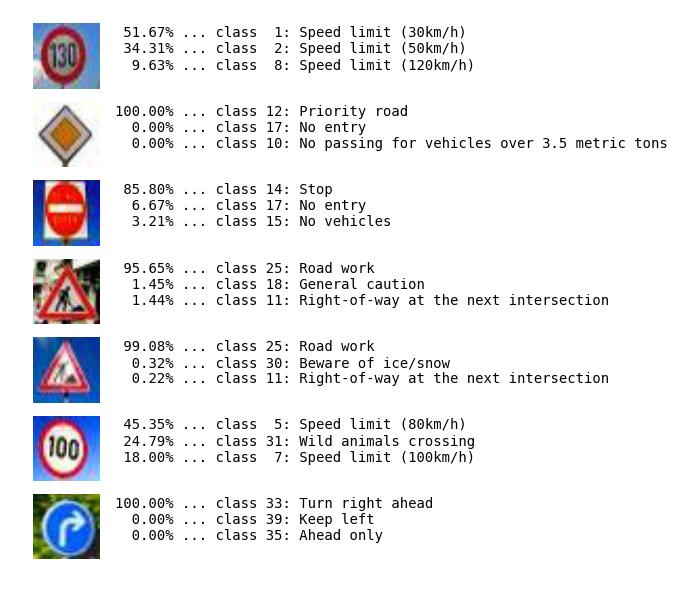

In [14]:
import glob
files = glob.glob('./custom_images/im*.jpg')
probs = tf.nn.top_k(tf.nn.softmax(logits),k=3)
plt.figure(figsize=(2,14))
counter = 1
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    for file in files:
        imf = plt.imread(file)
        out = sess.run(probs,feed_dict={x: np.array([imf]), keep_prob: 1.0})
        outstr = ""
        for pi,ii in zip(out.values[0],out.indices[0]):
            outstr += "\n{:6.2f}% ... class {:2}: {}".format(pi*100,ii,sign_names[ii][1])
            
        plt.subplot(14,2,counter)
        plt.imshow(imf)
        plt.axis('off')
        counter += 1
        
        plt.subplot(14,2,counter)
        plt.text(0.0,0.3,outstr,fontdict={'family':'monospace'})
        plt.axis('off')
        counter += 1

    plt.show()


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
Below section shows five candidate images from the testing data set and the top 3 predictions (including probabilities for each case). The images are not very clear at all and are very blurry and sometimes dar. At this resolution and image quality, it may be difficult even for a human to properly classify but this deep learning architecture seems to be doing a pretty good job.

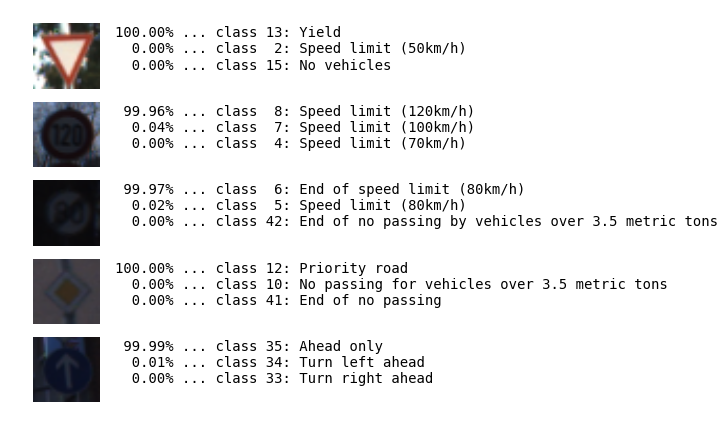

In [15]:
# Choosing 5 candidate images from test set
samples=np.random.choice(len(y_test),5,replace=False)
probs = tf.nn.top_k(tf.nn.softmax(logits),k=3)
plt.figure(figsize=(2,14))
counter = 1
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    for si in samples:
        out = sess.run(probs,feed_dict={x: np.array([X_test[si]]), keep_prob: 1.0})
        outstr = ""
        for pi,ii in zip(out.values[0],out.indices[0]):
            outstr += "\n{:6.2f}% ... class {:2}: {}".format(pi*100,ii,sign_names[ii][1])
            
        plt.subplot(14,2,counter)
        plt.imshow(X_test[si])
        plt.axis('off')
        counter += 1
        
        plt.subplot(14,2,counter)
        plt.text(0.0,0.3,outstr,fontdict={'family':'monospace'})
        plt.axis('off')
        counter += 1
            
    plt.show()
        

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
Above I show two sets of tests.
- The first set uses 7 custom images that were pulled from the internet (and cropped, resized etc). 
- The second set uses 5 ramdom samples from the original test set.

On the second set (original test set), the performance was very good. All five images were classified properly with high certainty despite the images being of poor quality.

However on the first set of 7 custom images the performance was not as good (5 out of 7 were properly classified). Of the two that were incorrectly classified:
- The first one was a sign that showed a speed limit of 130 km/h. This wasn't one of the 43 classes available and net thought the sign said 30 kmph limit. This is understandable.
- The other sign where it went wrong was for the one that said 100 kmph limit. This class was definitely available on the output layer as was nominated as second choice with 3% probability and the net seemed confident that it was actually a 80 kmph sign. This is completely wrong and needs to be investigated (training set examined).

#### Comparison on test set vs. captured images
- On the test set with 12630 samples, the accuracy achieved was ~ 94%
- On the captured images with 7 samples, the accuracy achieved was 5/7 ~ 71%. 

- If the example with 130 kmph limit sign is removed (there isn't an appropriate class available), then one could say the accuracy achieved was 5/6 ~ 83%. 

- **Upon futher examination of performance on captured images during resubmission, I see that the 80 kmph sign (the wrong class) had plenty of examples whereas the 100 kmph sign (the correct class) had much fewer examples and this data was augmented with duplicates. This may have resulted in overfitting and the data augmentation needs to be reexamined (perhaps geometric transformations like translation, skew etc need to be added).**

#### Update
After I reran all the cells, I see that the classification of the second captured image was also not perfect. It chose "STOP" as the top choice instead of "NO ENTRY". So the accuracy achieved drops to 4/6 ~ 66%


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**
For both evaluations above, the tf.nn_top_k function was used to provide top 3 choices.

Below, I have added the softmax visualizations for each of the captured images


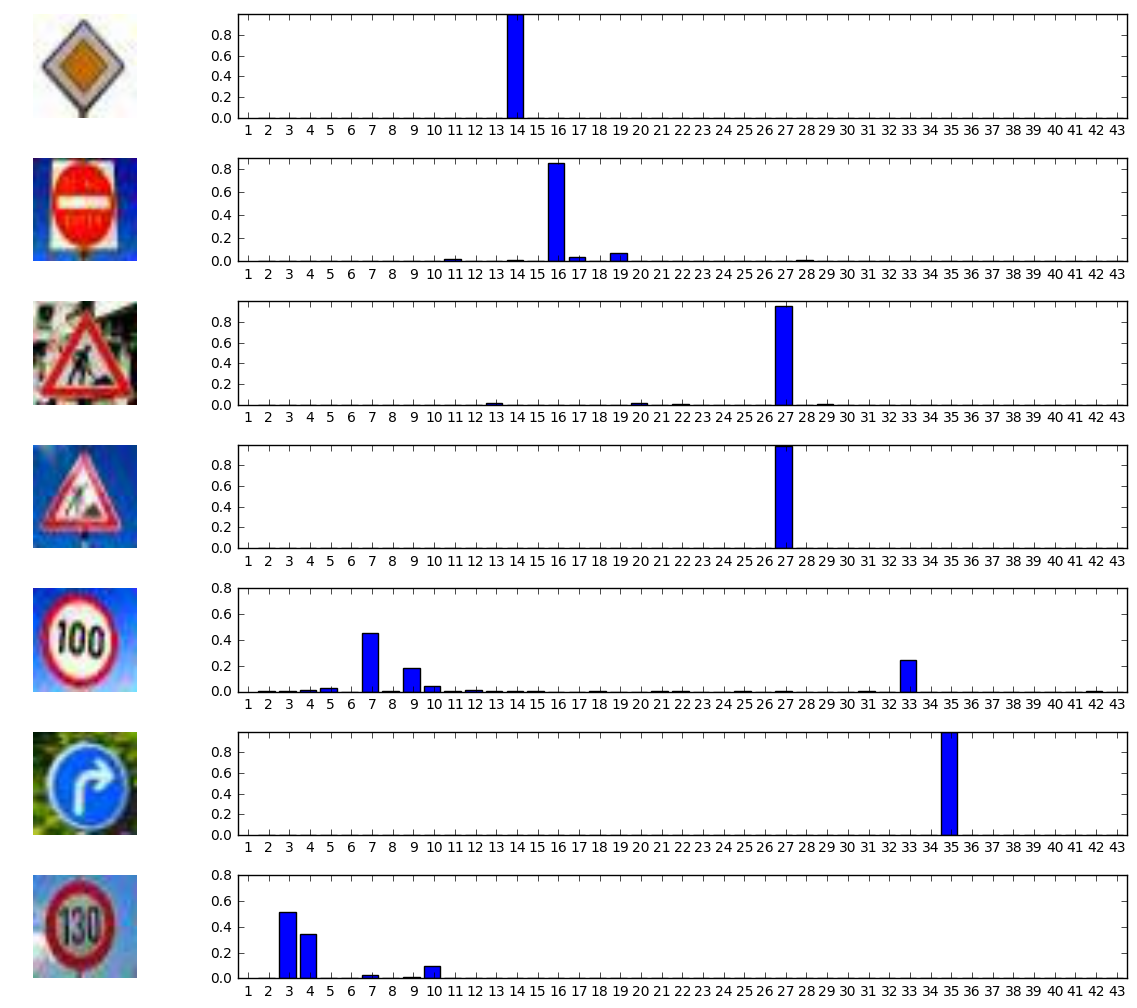


LEGEND:

0  : Speed limit (20km/h)
1  : Speed limit (30km/h)
2  : Speed limit (50km/h)
3  : Speed limit (60km/h)
4  : Speed limit (70km/h)
5  : Speed limit (80km/h)
6  : End of speed limit (80km/h)
7  : Speed limit (100km/h)
8  : Speed limit (120km/h)
9  : No passing
10 : No passing for vehicles over 3.5 metric tons
11 : Right-of-way at the next intersection
12 : Priority road
13 : Yield
14 : Stop
15 : No vehicles
16 : Vehicles over 3.5 metric tons prohibited
17 : No entry
18 : General caution
19 : Dangerous curve to the left
20 : Dangerous curve to the right
21 : Double curve
22 : Bumpy road
23 : Slippery road
24 : Road narrows on the right
25 : Road work
26 : Traffic signals
27 : Pedestrians
28 : Children crossing
29 : Bicycles crossing
30 : Beware of ice/snow
31 : Wild animals crossing
32 : End of all speed and passing limits
33 : Turn right ahead
34 : Turn left ahead
35 : Ahead only
36 : Go straight or right
37 : Go straight or left
38 : Keep right
39 : Keep left
40 : Roundabout m

In [16]:
import glob
files = glob.glob('./custom_images/im*.jpg')
probs = tf.nn.softmax(logits)
plt.figure(figsize=(12,10))
sign_names = np.array(sign_names)
counter = 0

with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    for file in files:
        imf = plt.imread(file)
        out = sess.run(probs,feed_dict={x: np.array([imf]), keep_prob: 1.0})
        
        xy = (counter-1,0)
        plt.subplot2grid((7,4),xy,colspan=1)
        plt.imshow(imf)
        plt.axis('off')
        
        xy = (counter-1,1)
        plt.subplot2grid((7,4),xy,colspan=3)
        plt.bar(range(1,n_classes+1),out[0])
        plt.xlim((0,43))
        plt.yticks(np.arange(0.0,1.0,0.2),np.arange(0.0,1.0,0.2))
        plt.xticks(np.arange(0.5,43.5,1.0),np.arange(1,44,1))
        counter += 1

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

print('\nLEGEND:\n')
for i in range(n_classes):
    print("{:3}: {}".format(sign_names[i,0],sign_names[i,1]))


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

# Result Logs

## v1.0 - Jan 21
- Original LeNet Architecture, No image enhancements, No augmentation, Using all RGB channels
- Epochs = 10
- VA = 0.959
- TA = 0.887

## V1.1 - Jan 21
- Added enhancement. Reduced accuracy
- VA = 0.930
- TA = 0.853

## V1.2 - Jan 21
- Added Dropout, No enhancement or normalization
- rate = 0.0005
- EPOCHS = 20
- BATCH_SIZE = 100
- KEEP_PROB = 0.75
- VA = 0.973
- TA = 0.913


## V1.3 - Jan 21
- Moved dropout to layer 3 (FC) instead of layer 4
- rate = 0.0005
- EPOCHS = 20
- BATCH_SIZE = 100
- KEEP_PROB = 0.7
- VA = 0.978
- TA = 0.920

## V1.4 - Jan 22
- Data augmentation (Added more images [duplicates i.e. without any transformations] where number of cases < 500)
- Inreased EPOCHS to 40
- VA = 0.990
- TA = 0.939

## V1.5 - Jan 22
- Increased threshold to 800
- Increaed KEEP_PROB to 0.6 (Increasing to 0.7 also gave almost same result)
- VA = 0.991
- TA = 0.943
